In [1]:
from google.colab import files
files.upload()

{}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install -q kaggle

In [5]:
!kaggle datasets download -d vaishaligbhujade/soybean-leaf-dataset-for-disease-classification

Dataset URL: https://www.kaggle.com/datasets/vaishaligbhujade/soybean-leaf-dataset-for-disease-classification
License(s): unknown


In [10]:
!unzip soybean-leaf-dataset-for-disease-classification.zip -d dataset/


Archive:  soybean-leaf-dataset-for-disease-classification.zip
  inflating: dataset/Bacterial Pustule/BP (1).jpg  
  inflating: dataset/Bacterial Pustule/BP (10).jpg  
  inflating: dataset/Bacterial Pustule/BP (100).jpg  
  inflating: dataset/Bacterial Pustule/BP (101).jpg  
  inflating: dataset/Bacterial Pustule/BP (102).jpg  
  inflating: dataset/Bacterial Pustule/BP (103).jpg  
  inflating: dataset/Bacterial Pustule/BP (104).jpg  
  inflating: dataset/Bacterial Pustule/BP (105).jpg  
  inflating: dataset/Bacterial Pustule/BP (106).jpg  
  inflating: dataset/Bacterial Pustule/BP (107).jpg  
  inflating: dataset/Bacterial Pustule/BP (108).jpg  
  inflating: dataset/Bacterial Pustule/BP (109).jpg  
  inflating: dataset/Bacterial Pustule/BP (11).jpg  
  inflating: dataset/Bacterial Pustule/BP (110).jpg  
  inflating: dataset/Bacterial Pustule/BP (12).jpg  
  inflating: dataset/Bacterial Pustule/BP (13).jpg  
  inflating: dataset/Bacterial Pustule/BP (14).jpg  
  inflating: dataset/Bacter

In [6]:
!pip install tensorflow keras scikit-learn matplotlib imutils seaborn


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, schedules
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, mean_squared_log_error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import csv
from PIL import Image
import json


In [11]:
os.listdir("/content/dataset")


['Rust',
 'Yellow Mosaic',
 'Frogeye Leaf Spot',
 'Sudden Death Syndrome',
 'Healty',
 'Bacterial Pustule',
 'Target Leaf Spot']

In [14]:
EPOCHS = 20
BS = 8
DIRECTORY = "/content/dataset"

# CATEGORIES = os.listdir(DIRECTORY)
CATEGORIES = ['Healty', 'Yellow Mosaic', 'Sudden Death Syndrome', 'Bacterial Pustule', 'Rust']
data = []
labels = []

foldername = "VGG16"

In [15]:
data = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        # Convert image to grayscale
        gray_image = Image.open(img_path)
        # Resize if needed (optional)
        gray_image = gray_image.resize((224, 224))
        # Convert to array
        image_array = img_to_array(gray_image)
        image_array = preprocess_input(image_array)
        data.append(image_array)
        labels.append(category)

In [16]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data , dtype="float32")
labels = np.array(labels)

In [17]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20,  random_state=42)

In [18]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.2,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
    vertical_flip = True,
	fill_mode="nearest")

In [19]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in baseModel.layers:
	layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
topModel = baseModel.output
topModel = AveragePooling2D(pool_size=(7, 7))(topModel)
topModel = Flatten(name="flatten")(topModel)
topModel = Dense(128, activation="relu")(topModel)
topModel = Dropout(0.5)(topModel)
topModel = Dense(len(CATEGORIES), activation="softmax")(topModel)

In [21]:
model = Model(inputs=baseModel.input, outputs=topModel)


In [23]:
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9
    )
opt = Adam(learning_rate = lr_schedule)


In [24]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])


In [25]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 249ms/step - accuracy: 0.3352 - loss: 8.7643 - val_accuracy: 0.8091 - val_loss: 0.5900
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.5602 - loss: 1.0322 - val_accuracy: 0.6818 - val_loss: 0.7176
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.5933 - loss: 0.9555 - val_accuracy: 0.7000 - val_loss: 0.6281
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.6636 - loss: 0.8910 - val_accuracy: 0.7727 - val_loss: 0.4854
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.5459 - loss: 1.0551 - val_accuracy: 0.6727 - val_loss: 0.8912
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.6745 - loss: 0.8457 - val_accuracy: 0.7636 - val_loss: 0.5362
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.6215 - loss: 0.8826 - val_accuracy: 0.7273 - val_loss: 0.4837
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.6315 - loss: 0.7674 - val_accuracy: 0.6727 - v

In [26]:
model.save(f'{foldername}/model_2_new_dataset.h5', 'h5')


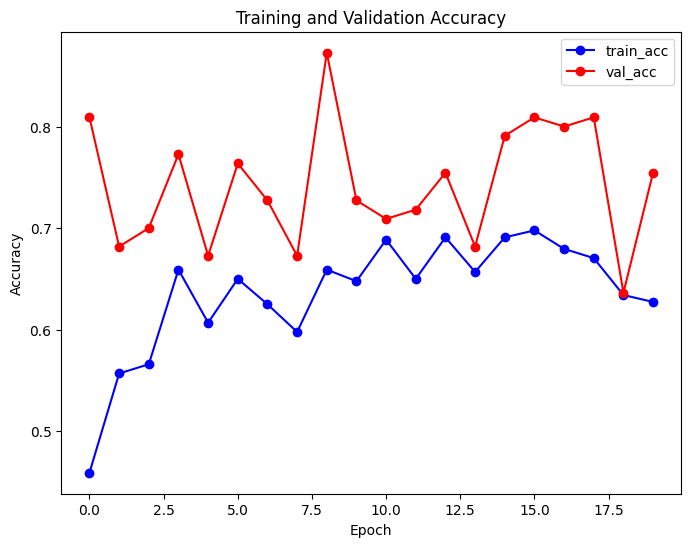

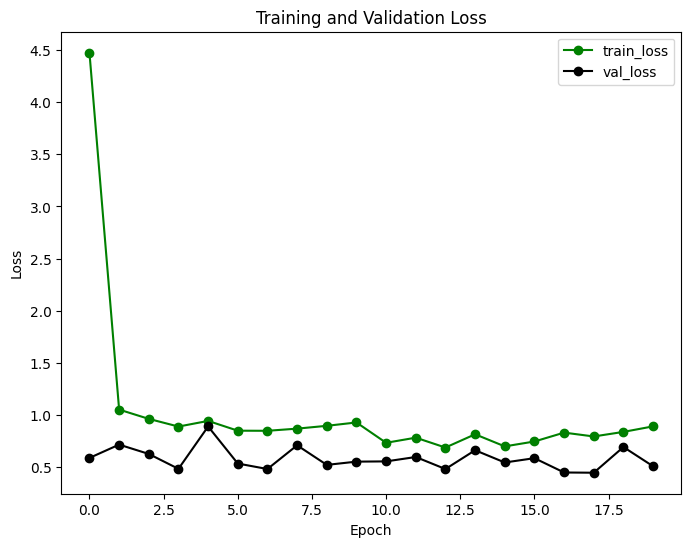

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc", c="Blue", marker='o')
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc", c="Red", marker='o')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"{foldername}/accuracy.png")

# Create a figure for accuracy
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss", c="Green", marker='o')
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss", c="Black", marker='o')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"{foldername}/loss.png")

In [28]:
with open(f"{foldername}/history.json", 'w') as file:
    json.dump(H.history, file)